# load library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from catboost import cv, Pool

plt.rcParams['font.family'] = 'Malgun Gothic'

# load data

In [9]:
k_df = pd.read_csv('preprocessed data/k_df.csv', index_col=0) # cluster에 대한 데이터
combined_df = pd.read_csv('preprocessed data/combined_df.csv',index_col=0) #원본 데이터

# data preprocessing

In [10]:
# interpolation이 진행됐던 index의 '모름' 데이터를 보간
combined_df.loc[k_df.index,'INCOME'] = k_df['INCOME']

# 0번 클러스터 인덱스 추출
cluster0_indices = k_df[k_df['kmeans_cluster'] == 0].index
# 인덱스 조건에 따라 값 할당(cluster 값이 0이면 1로 나머지는 0으로)
combined_df['kmeans_cluster'] = combined_df.index.isin(cluster0_indices).astype(int)

# 서울특별시, 경기도, 인천광역시 시민 인덱싱
combined_df = combined_df[(combined_df['AREA']=='서울특별시')]

# catboost modeling

In [21]:
# 1. 데이터 전처리
train_df = combined_df[['SEX', 'AGE', 'INCOME','kmeans_cluster']]
X = train_df.drop('kmeans_cluster',axis=1)
y = train_df['kmeans_cluster']
cat_features = ['SEX', 'AGE','INCOME']

# 2. CatBoost 전용 Pool 생성
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 3. cv() 파라미터 설정 및 실행
cv_params = {
    'iterations': 1000,
    'learning_rate': 0.5,            # 필요시 세부 조정
    'loss_function': 'Logloss',
    'early_stopping_rounds': 100,
    'verbose': 50
}
cv_results = cv(
    params=cv_params,
    pool=train_pool,
    fold_count=5,      # 보통 5~10
    shuffle=True,
    stratified=True,   # 다중분류에서는 꼭 True 권장
)


Training on fold [0/5]
0:	learn: 0.1856796	test: 0.1908262	best: 0.1908262 (0)	total: 10.7ms	remaining: 10.7s
50:	learn: 0.0522825	test: 0.1064990	best: 0.0708448 (6)	total: 3.95s	remaining: 1m 13s
100:	learn: 0.0480418	test: 0.1169216	best: 0.0708448 (6)	total: 9.22s	remaining: 1m 22s

bestTest = 0.0708447994
bestIteration = 6

Training on fold [1/5]
0:	learn: 0.1872044	test: 0.1813772	best: 0.1813772 (0)	total: 10.2ms	remaining: 10.1s
50:	learn: 0.0548429	test: 0.0792420	best: 0.0656401 (8)	total: 3.73s	remaining: 1m 9s
100:	learn: 0.0505091	test: 0.0825523	best: 0.0656401 (8)	total: 8.16s	remaining: 1m 12s

bestTest = 0.06564009913
bestIteration = 8

Training on fold [2/5]
0:	learn: 0.1863355	test: 0.1867508	best: 0.1867508 (0)	total: 12.8ms	remaining: 12.8s
50:	learn: 0.0572456	test: 0.0969075	best: 0.0712389 (13)	total: 3.58s	remaining: 1m 6s
100:	learn: 0.0511265	test: 0.1110371	best: 0.0712389 (13)	total: 8.19s	remaining: 1m 12s

bestTest = 0.07123887751
bestIteration = 13

Trai

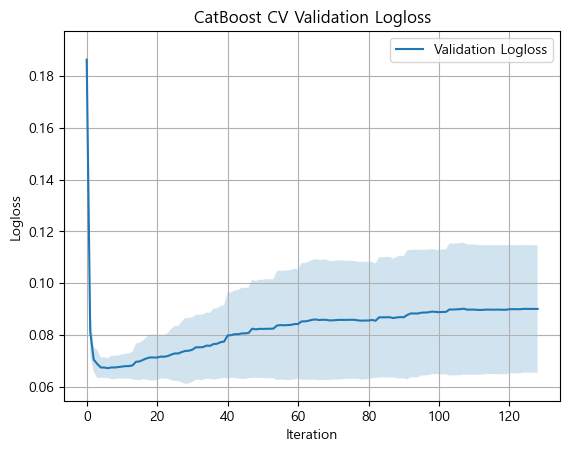

In [22]:
plt.plot(cv_results['test-Logloss-mean'], label='Validation Logloss')
plt.fill_between(
    cv_results.index,
    cv_results['test-Logloss-mean'] - cv_results['test-Logloss-std'],
    cv_results['test-Logloss-mean'] + cv_results['test-Logloss-std'],
    alpha=0.2
)
plt.xlabel("Iteration")
plt.ylabel("Logloss")
plt.title("CatBoost CV Validation Logloss")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# validation(Logloss)이 가장 낮은 반복 찾기
best_iteration = cv_results['test-Logloss-mean'].idxmin()
print("Best iteration:", best_iteration)

final_model = CatBoostClassifier(
    iterations=best_iteration,
    learning_rate=0.5,
    loss_function='Logloss',
    cat_features=cat_features,
    verbose=50,
    random_seed=42
)

# 전체 데이터를 사용하여 모델 학습
final_model.fit(X, y)


Best iteration: 6
0:	learn: 0.3697700	total: 11ms	remaining: 55ms
5:	learn: 0.0950124	total: 97.2ms	remaining: 0us


SEX: 42.7399
AGE: 0.0000
INCOME: 57.2601


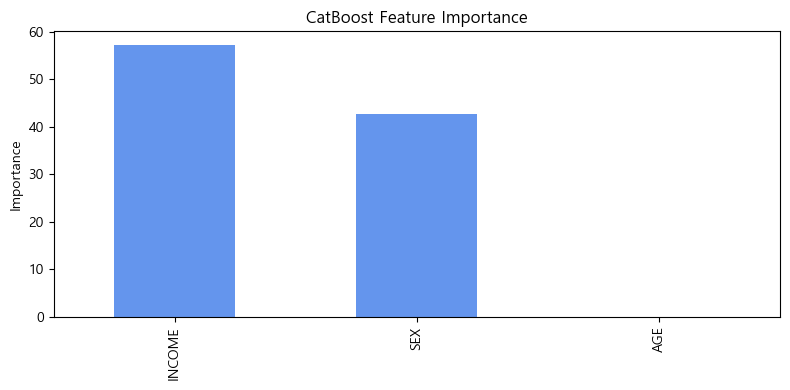

In [24]:
# 중요도 추출
importances = final_model.get_feature_importance()
features = X.columns  # 또는 사용한 feature 이름 리스트

for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

fi = pd.Series(importances, index=features).sort_values(ascending=False)

# 시각화
fi.plot(kind='bar', figsize=(8,4), color='cornflowerblue')
plt.title('CatBoost Feature Importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [26]:
#모델 저장
final_model.save_model("model/catboost_clustering.cbm")

#모델 불러오기
loaded_model = CatBoostClassifier()
loaded_model.load_model("model/catboost_clustering.cbm")